In [2]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00a 0:00:01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, make_scorer


In [8]:
df = pd.read_csv('./data/cleaned_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431001 entries, 0 to 431000
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wind_direction      431001 non-null  float64       
 1   building_id         431001 non-null  int64         
 2   timestamp           431001 non-null  datetime64[ns]
 3   meter_reading       431001 non-null  float64       
 4   primary_use         431001 non-null  object        
 5   square_feet         431001 non-null  int64         
 6   year_built          431001 non-null  int64         
 7   cloud_coverage      431001 non-null  float64       
 8   air_temperature     431001 non-null  float64       
 9   dew_temperature     431001 non-null  float64       
 10  sea_level_pressure  431001 non-null  float64       
 11  wind_speed          431001 non-null  float64       
 12  hour                431001 non-null  int64         
 13  month               431001 no

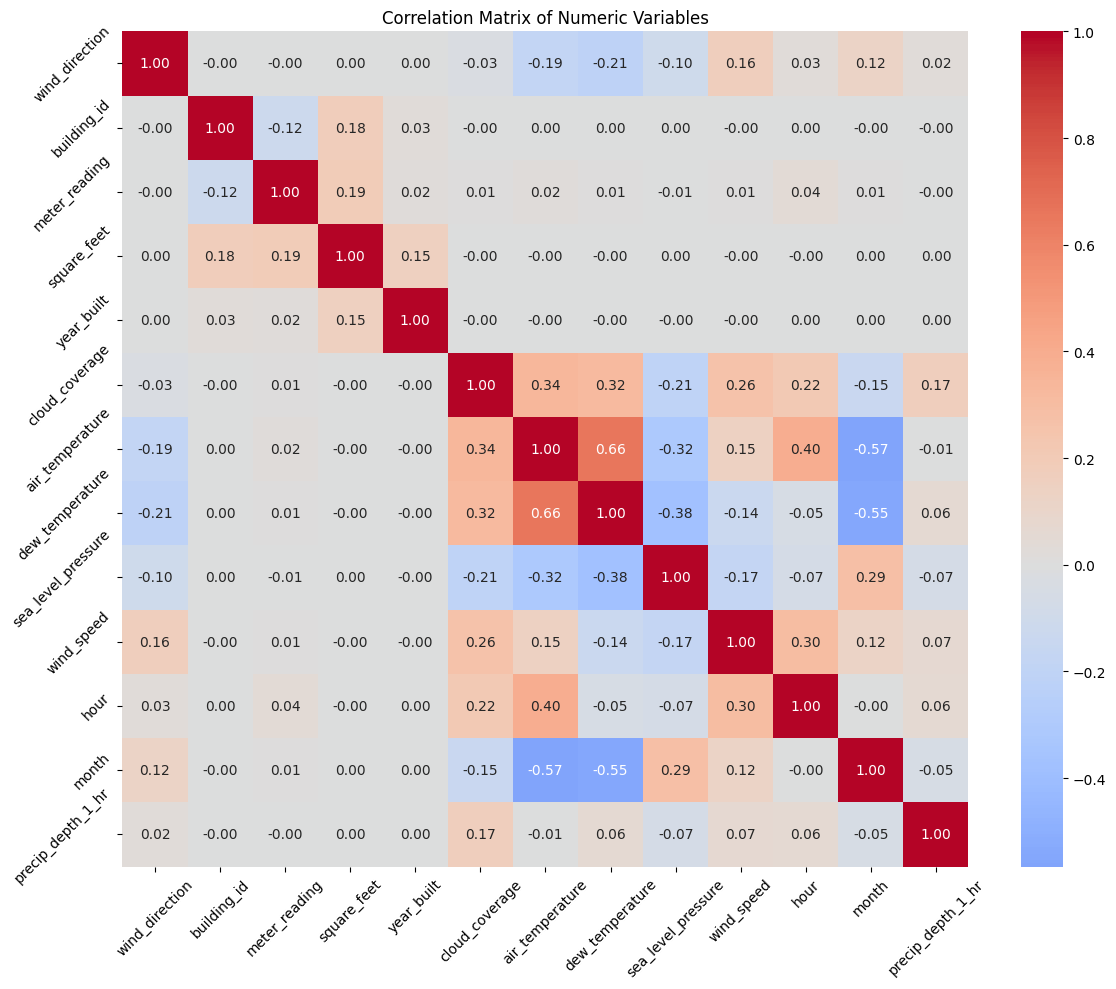

In [7]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
train_mask = df.timestamp <  "2016-11-01"
val_mask   = (df.timestamp >= "2016-11-01") & (df.timestamp < "2016-12-01")
test_mask  = df.timestamp >=  "2016-12-01"

df["y_log"] = np.log1p(df["meter_reading"])


In [10]:
# Clipping threshold from train only
P998 = df.loc[train_mask, "meter_reading"].quantile(0.998)

# Apply clipping & spike flag
df["meter_clipped"] = df["meter_reading"].clip(upper=P998)
df["spike_flag"]    = (df["meter_reading"] > P998).astype(int)

In [ ]:
WEATHER = [
    "air_temperature",
    "dew_temperature",
    "sea_level_pressure",
    "wind_speed",
    "wind_direction",
    "cloud_coverage",
    "precip_depth_1_hr",
]


def make_features(
    df: pd.DataFrame,
    roll_hrs=(24, 168),
    lag_hrs=(1, 24),
    weather_cols=WEATHER,
):

    df = df.copy()
    ts = df["timestamp"]

    df["hour"]       = ts.dt.hour
    df["weekday"]    = ts.dt.weekday                # 0 = Monday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["month"]      = ts.dt.month

    # cyclic encodings
    df["hour_sin"]  = np.sin(2 * np.pi * df["hour"]  / 24)
    df["hour_cos"]  = np.cos(2 * np.pi * df["hour"]  / 24)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    df["log_sqft"]     = np.log1p(df["square_feet"])
    df["building_age"] = ts.dt.year - df["year_built"]

    # categorical dtypes for tree‑boosters
    df["primary_use"] = df["primary_use"].astype("category")
    df["building_id"] = df["building_id"].astype("category")
    df.sort_values(["building_id", "timestamp"], inplace=True)
    grp = df.groupby("building_id", group_keys=False)

    for r in roll_hrs:
        df[f"meter_mean_{r}h"] = grp["meter_clipped"].transform(
            lambda x: x.rolling(r, min_periods=1).mean()
        )
        df[f"meter_std_{r}h"] = grp["meter_clipped"].transform(
            lambda x: x.rolling(r, min_periods=1).std()
        ).fillna(0)
        df[f"meter_min_{r}h"] = grp["meter_clipped"].transform(
            lambda x: x.rolling(r, min_periods=1).min()
        )

    for l in lag_hrs:
        df[f"meter_lag_{l}h"] = grp["meter_clipped"].shift(l)

    for col in weather_cols:
        for l in lag_hrs:
            df[f"{col}_lag{l}h"] = grp[col].shift(l)
        for r in roll_hrs:
            df[f"{col}_mean_{r}h"] = grp[col].transform(
                lambda x: x.rolling(r, min_periods=1).mean()
            )

    feature_cols = (
        ["hour_sin", "hour_cos", "weekday", "is_weekend",
         "month_sin", "month_cos"] +
        ["log_sqft", "building_age"] +
        weather_cols +
        [f"{c}_lag{l}h"   for c in weather_cols for l in lag_hrs] +
        [f"{c}_mean_{r}h" for c in weather_cols for r in roll_hrs] +
        [f"meter_lag_{l}h"  for l in lag_hrs] +
        [f"meter_mean_{r}h" for r in roll_hrs] +
        [f"meter_std_{r}h"  for r in roll_hrs] +
        [f"meter_min_{r}h"  for r in roll_hrs] +
        (["spike_flag"] if "spike_flag" in df.columns else []) +
        ["primary_use", "building_id"]
    )

    return df[feature_cols]


In [12]:

X_train, y_train = make_features(df.loc[train_mask]), df.loc[train_mask, "y_log"]
X_val,   y_val   = make_features(df.loc[val_mask]),   df.loc[val_mask,   "y_log"]
X_test,  y_test  = make_features(df.loc[test_mask]),  df.loc[test_mask,  "y_log"]

/var/folders/6q/pmrz1w_935lc5f08sxm0smhm0000gn/T/ipykernel_4246/3049970516.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("building_id", group_keys=False)
/var/folders/6q/pmrz1w_935lc5f08sxm0smhm0000gn/T/ipykernel_4246/3049970516.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("building_id", group_keys=False)
/var/folders/6q/pmrz1w_935lc5f08sxm0smhm0000gn/T/ipykernel_4246/3049970516.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

In [17]:
lgbm = lgb.LGBMRegressor(
    objective          = "tweedie",
    tweedie_variance_power = 1.1,     # 1.0 ≈ Poisson, 2.0 ≈ Gamma – 1.1 works well for energy
    n_estimators       = 10_000,      
    learning_rate      = 0.03,
    num_leaves         = 512,
    feature_fraction   = 0.85,
    bagging_fraction   = 0.85,
    bagging_freq       = 5,
    min_data_in_leaf   = 50,
    random_state       = 42,
    metric             = "rmse",     
)

lgbm.fit(
    X_train, y_train,
    eval_set     = [(X_val, y_val)],
    categorical_feature = "auto",    
    callbacks    = [
        early_stopping(stopping_rounds=300, verbose=False),
        log_evaluation(period=200),
    ],
)



[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-thr

KeyboardInterrupt: 

In [ ]:
best_iter = lgbm.best_iteration_
val_rmse_log = lgbm.best_score_["valid_0"]["rmse"]
print(f"\nBest iteration : {best_iter}")
print(f"Log‑space RMSE : {val_rmse_log:.5f}")

y_hat_val  = lgbm.predict(X_val,  num_iteration=best_iter)
y_hat_test = lgbm.predict(X_test, num_iteration=best_iter)

rmse_val  = np.sqrt(((np.expm1(y_hat_val)  - np.expm1(y_val)) )**2).mean()**0.5
rmse_test = np.sqrt(((np.expm1(y_hat_test) - np.expm1(y_test)) )**2).mean()**0.5

print(f"Back transformed RMSE (validation) : {rmse_val:,.2f} kWh")
print(f"Back transformed RMSE (test)       : {rmse_test:,.2f} kWh")

### XGBoost

In [ ]:
neg_rmse = make_scorer(
    lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)),
    greater_is_better=False
)

X_tune   = np.vstack([X_train, X_val])
y_tune   = np.concatenate([y_train, y_val])

test_fold = np.concatenate([
    -1 * np.ones(len(y_train), dtype=int),   # training rows
     np.zeros(len(y_val),   dtype=int)       # validation rows
])
ps = PredefinedSplit(test_fold)


base_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
)

param_grid = {
    "n_estimators":        [600, 1200, 2000],
    "learning_rate":       [0.03, 0.05, 0.1],
    "max_depth":           [4, 6, 8],
    "min_child_weight":    [1, 5, 10],
    "subsample":           [0.8, 1.0],
    "colsample_bytree":    [0.8, 1.0],
    "gamma":               [0, 1],
    "reg_lambda":          [1.0, 3.0],
}

grid = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring=neg_rmse,
    cv=ps,
    verbose=2,
    n_jobs=-1,
)

grid.fit(X_tune, y_tune)

best_params   = grid.best_params_
best_rmse_log = -grid.best_score_
print("\nBest validation RMSE (log space): {:.5f}".format(best_rmse_log))
print("Best hyper parameters:")
for k, v in best_params.items():
    print(f"  {k:<18} {v}")


best_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    **best_params
)

best_model.fit(X_tune, y_tune)

y_hat_test_log = best_model.predict(X_test)
rmse_test_kwh  = np.sqrt(
    mean_squared_error(np.expm1(y_test), np.expm1(y_hat_test_log))
)

print("\nDecember test RMSE : {:.2f} kWh".format(rmse_test_kwh))


🔍  Running GridSearchCV (this may take several minutes)…
Fitting 1 folds for each of 1296 candidates, totalling 1296 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=1.0, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=1.0, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=3.0, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=3.0, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1200, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_depth=4,

/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=10, n_estimators=2000, reg_lambda=3.0, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=1.0, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=1.0, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=3.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, reg_lambda=3.0, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=1200, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, g

ValueError: 
All the 1296 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1296 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/data.py", line 1441, in _proxy_transform
    data, _ = _ensure_np_dtype(data, data.dtype)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/satyabratsrikumar/anaconda3/envs/myenvironment/lib/python3.12/site-packages/xgboost/data.py", line 224, in _ensure_np_dtype
    data = data.astype(dtype, copy=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Education'
